In [12]:
#Подключение библеотек
import pandas 
import matplotlib.pyplot as plt
from re import sub
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [13]:
#Чтение с JSON
dataset = pandas.read_json("data.json")
dataset

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [14]:
#Удаление колонки id
dataset = dataset.drop(columns="id")

In [15]:
#Кол-во классов в датасете
class_label_len = len(dataset["cuisine"].unique()) #подсчет классов 
print(class_label_len)

20


In [16]:
ingridient_replace = {
    "knorr": "",
    "sargento": "",
    "wishbone": "",
    "hiddenvalley": "",
    "kraft": "",
    'wasabe': 'wasabi',
    'sauc': 'sauce',
}

#Функция очистки датасета
def clear_dataframe(dataset):
    for i in range(len(dataset["ingredients"])):
        for j in range(len(dataset["ingredients"][i])): # Каждый ингридиент
            dataset["ingredients"][i][j] = sub("[^A-Za-z]", " " , dataset["ingredients"][i][j])#Оставляем все кроме букв
            dataset["ingredients"][i][j] = sub("[0-9]", " " , dataset["ingredients"][i][j])#Удаляем все цифры
            dataset["ingredients"][i][j] = dataset["ingredients"][i][j].lower()#Приводим к нижнему регистру
            for key, value in ingridient_replace.items():
                dataset["ingredients"][i][j].replace(key, value)#Убираем заменяем данные на основе списка(выше блок)
            dataset["ingredients"][i][j] = dataset["ingredients"][i][j].replace(' ', '')#
    return dataset

In [17]:
dataset = clear_dataframe(dataset)

<Axes: xlabel='cuisine'>

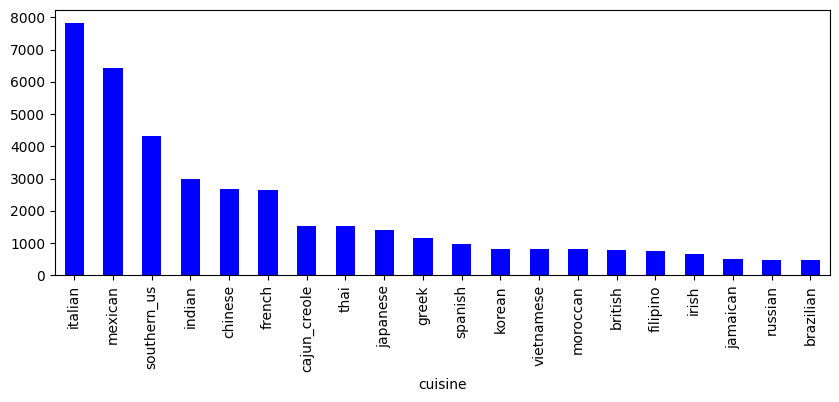

In [18]:
plt.figure(figsize = (10,20))
plt.subplot(5, 1, 1)
dataset["cuisine"].value_counts().plot.bar(color="b")

<Axes: title={'center': 'Наибольшее кол-во ингредиентов в датасете'}>

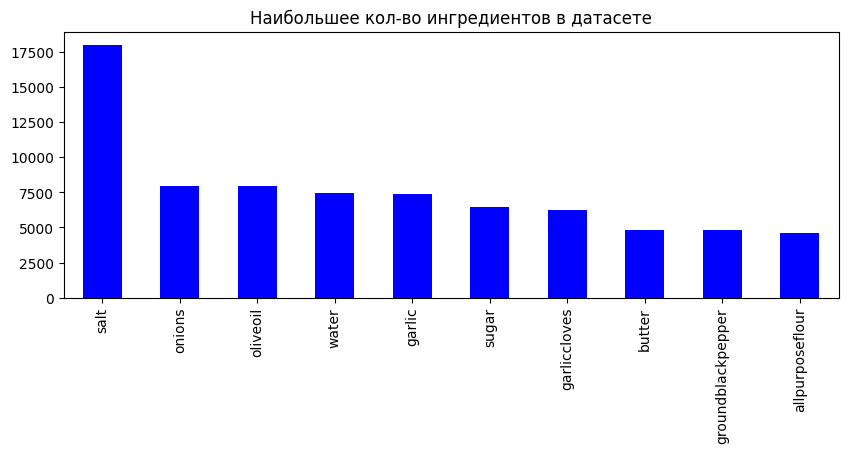

In [19]:
plt.figure(figsize = (10,20))
plt.subplot(5, 1, 2)
pandas.Series(dict(Counter(','.join(j for i in dataset["ingredients"] for j in i).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="b", title="Наибольшее кол-во ингредиентов в датасете")

<Axes: title={'center': 'Наибольшее кол-во ингредиентов в датасете Италия'}>

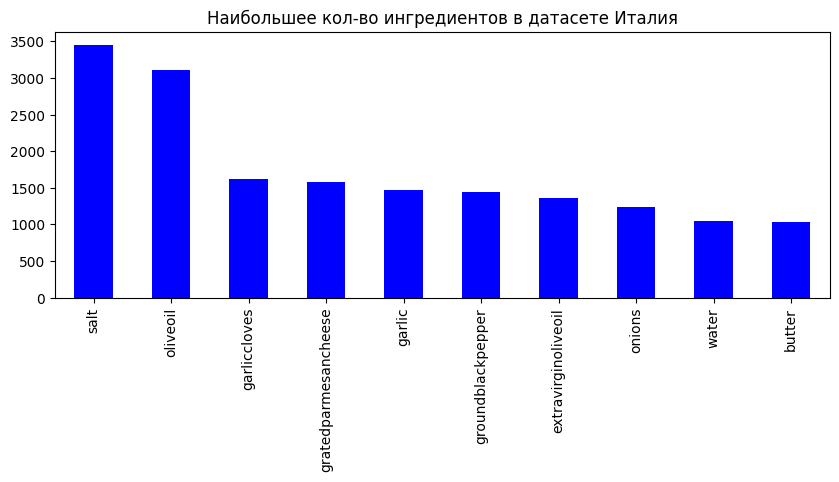

In [20]:
plt.figure(figsize = (10,20))
plt.subplot(5, 1, 3)
pandas.Series(dict(Counter(','.join(j for i in dataset.loc[dataset["cuisine"] == "italian"]["ingredients"] for j in i).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="b", title="Наибольшее кол-во ингредиентов в датасете Италия")
   

<Axes: title={'center': 'Наибольшее кол-во ингредиентов в датасете Корея'}>

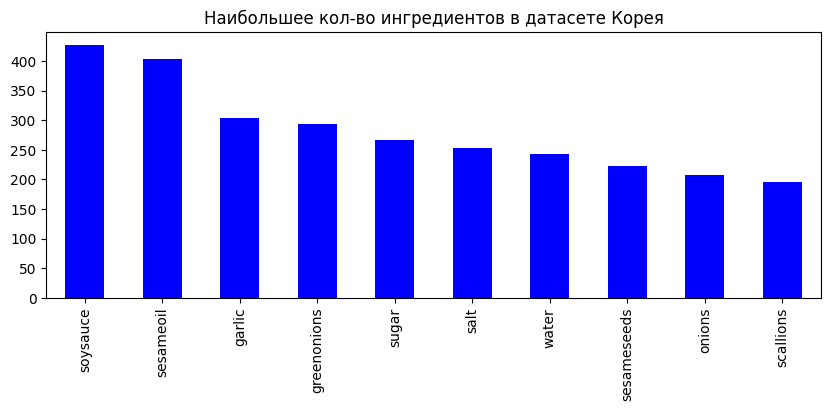

In [21]:
plt.figure(figsize = (10,20))
plt.subplot(5, 1, 4)
pandas.Series(dict(Counter(','.join(j for i in dataset.loc[dataset["cuisine"] == "korean"]["ingredients"] for j in i).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="b", title="Наибольшее кол-во ингредиентов в датасете Корея")
   

<Axes: title={'center': 'Наибольшее кол-во ингредиентов в датасете Россия'}>

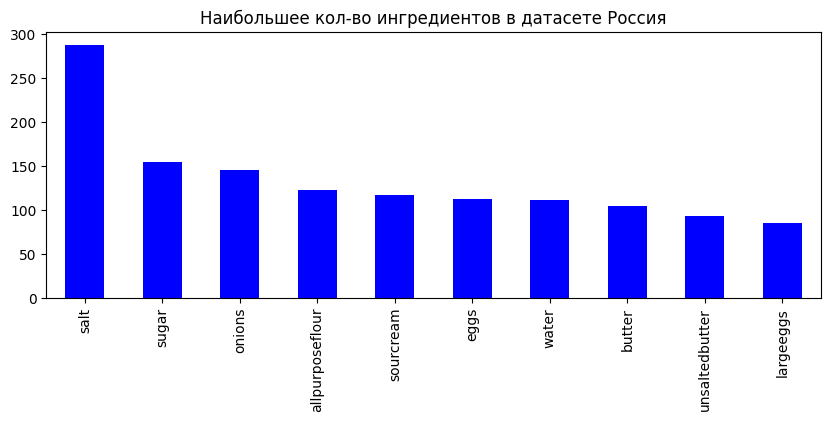

In [22]:
plt.figure(figsize = (10,20))
plt.subplot(5, 1, 5)
pandas.Series(dict(Counter(','.join(j for i in dataset.loc[dataset["cuisine"] == "russian"]["ingredients"] for j in i).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="b", title="Наибольшее кол-во ингредиентов в датасете Россия")
   

In [23]:
#Словарь {Кухня: ID}
class_label = dataset["cuisine"].unique() 
class_label = dict(zip(class_label,[i for i in range(class_label_len)])) 
print(class_label)

{'greek': 0, 'southern_us': 1, 'filipino': 2, 'indian': 3, 'jamaican': 4, 'spanish': 5, 'italian': 6, 'mexican': 7, 'chinese': 8, 'british': 9, 'thai': 10, 'vietnamese': 11, 'cajun_creole': 12, 'brazilian': 13, 'french': 14, 'japanese': 15, 'irish': 16, 'korean': 17, 'moroccan': 18, 'russian': 19}


In [24]:
#Заменяем кухню на id
dataset["cuisine"] = dataset["cuisine"].replace((class_label))
print(dataset)

       cuisine                                        ingredients
0            0  [romainelettuce, blackolives, grapetomatoes, g...
1            1  [plainflour, groundpepper, salt, tomatoes, gro...
2            2  [eggs, pepper, salt, mayonaise, cookingoil, gr...
3            3                 [water, vegetableoil, wheat, salt]
4            3  [blackpepper, shallots, cornflour, cayennepepp...
...        ...                                                ...
39769       16  [lightbrownsugar, granulatedsugar, butter, war...
39770        6  [kraftzestyitaliandressing, purpleonion, brocc...
39771       16  [eggs, citrusfruit, raisins, sourdoughstarter,...
39772        8  [bonelesschickenskinlessthigh, mincedgarlic, s...
39773        7  [greenchile, jalapenochilies, onions, groundbl...

[39774 rows x 2 columns]


In [25]:
#Подсчет уникальных продуктов
all_ingridients = []
for i, name in enumerate(dataset["ingredients"]):
    for j, name1 in enumerate(dataset["ingredients"][i]):
        all_ingridients.append(name1)

print(len(pandas.unique(all_ingridients)))

6642


C:\Users\Алексей\AppData\Local\Temp\ipykernel_4564\1283239402.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(len(pandas.unique(all_ingridients)))


In [26]:
#Горячее кодирование 
mlb = MultiLabelBinarizer(sparse_output=True)
dataset1 = mlb.fit_transform(dataset["ingredients"])

In [27]:
#Разбивка на тренировочную и тестовую выборки
train, test, label_train, label_test = train_test_split(dataset1, dataset["cuisine"], test_size=0.30, random_state=527)

In [28]:
train

<27841x6642 sparse matrix of type '<class 'numpy.int32'>'
	with 299216 stored elements in Compressed Sparse Row format>

In [55]:
#Подбор гипер параметров для Логистической регрессии
logisticRegr = LogisticRegression(random_state=76, max_iter=450)
GSCV_for_LR = GridSearchCV(estimator=logisticRegr, param_grid={"C":[1.2, 1.4, 1.6, 1.8], "solver":['newton-cg', 'sag','saga']})
GSCV_for_LR.fit(train, label_train)
print(GSCV_for_LR.best_params_)


{'C': 1.4, 'solver': 'saga'}


In [47]:
#Подбор гипер параметров для Случайного леса
model_tree = RandomForestClassifier(n_estimators=200)
GSCV_for_RFC = GridSearchCV(estimator=model_tree, param_grid={"max_depth": [None, 5, 10]})
GSCV_for_RFC.fit(train, label_train)
print(GSCV_for_RFC.best_params_)

{'max_depth': None}


In [54]:
neigh = KNeighborsClassifier(algorithm="brute")
GSCV_for_neigh = GridSearchCV(estimator=neigh, param_grid={"n_neighbors": [7, 10, 15], "p":[1, 2]})
GSCV_for_neigh.fit(train, label_train)
print(GSCV_for_neigh.best_params_)

{'n_neighbors': 15, 'p': 1}


In [62]:
#Подбор гипер параметров для Метода k-ближайших соседей
logisticRegr = LogisticRegression(random_state=76, max_iter=450, C=GSCV_for_LR.best_params_.get("C"), solver=GSCV_for_LR.best_params_.get("solver"))
logisticRegr.fit(train, label_train)
accuracy_logisticRegr = accuracy_score(label_test, logisticRegr.predict(test))
print("Точность:{} %".format(round(accuracy_logisticRegr*100, 2))) 

Точность:77.42 %


In [63]:
#Случайный лес (проверяет все возможные разделения)
model_tree = RandomForestClassifier(n_estimators=200, max_depth=GSCV_for_RFC.best_params_.get("max_depth"))
model_tree.fit(train, label_train)
accuracy_model_tree = accuracy_score(label_test, model_tree.predict(test))
print("Точность:{} %".format(round(accuracy_model_tree*100, 2)))

Точность:71.15 %


In [64]:
#Метод k-ближайших соседей
neigh = KNeighborsClassifier(n_neighbors=GSCV_for_neigh.best_params_.get("n_neighbors"), algorithm="brute", p=GSCV_for_neigh.best_params_.get("p"))
neigh.fit(train, label_train)
accuracy_model_neigh = accuracy_score(label_test, neigh.predict(test))
print("Точность:{}%".format(round(accuracy_model_neigh*100, 2)))

Точность:50.78%


In [65]:
#Метод k-средних(Он не подходит к классификации и метрика точность будет низкой)
kmeans = KMeans(n_clusters=20, random_state=123, n_init="auto")
kmeans.fit(train, label_train)
accuracy_model_kmeans = accuracy_score(label_test, kmeans.predict(test))
print("Точность:{} %".format(round(accuracy_model_kmeans*100, 2)))


Точность:3.33 %


<BarContainer object of 4 artists>

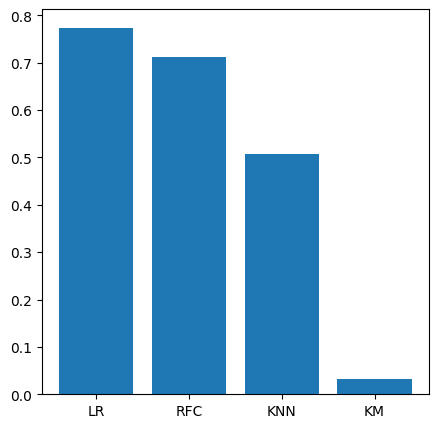

In [67]:
#Графики точности каждой модели
x = ["LR","RFC", "KNN","KM"]
y = [accuracy_logisticRegr, accuracy_model_tree, accuracy_model_neigh, accuracy_model_kmeans]
plt.figure(figsize=(5,5))
plt.bar(x, y)